# Transformers

 HuggingFace의 [Transformer](https://huggingface.co/transformers/index.html) 라이브러리를 이용해 BERT Classification 모델을 구현한다. Naver Movie 감성분석 문제를 푼다.

#===================================

# _0_. Importing Modules

In [1]:
!pip install transformers

In [2]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
# from transformers import BertConfig, TFTrainer, TFTrainingArguments

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from IPython.display import SVG
from keras.utils import model_to_dot
import matplotlib.pyplot as plt

In [3]:
# 경로 설정
model_path = "/content/drive/My Drive/BERT"
data_path = "/content/drive/My Drive/dataset"
TRAIN_PATH = f"{data_path}/ratings_train.txt"
TEST_PATH = f"{data_path}/ratings_test.txt"

# _1_. Preprocessing Data

In [4]:
# 전처리
def preprocess_data(x):
    x_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ ]", "", str(x)) # 한글, 공백 제외 제거
    return x_clean

## Train

In [5]:
# 데이터 로드
train_data = pd.read_csv(TRAIN_PATH, header=0, delimiter='\t', quoting=3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
# 결측치 제거
print(train_data.isnull().sum())
train_data = train_data.dropna()
train_data.info()

id          0
document    5
label       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [7]:
# 한글만 남기기
train_data['document'] = train_data['document'].apply(lambda x: preprocess_data(x))
display(train_data)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [8]:
# 빈 데이터 제거
drop_train = [idx for idx, sent in enumerate(train_data['document']) if len(sent) < 1]
train_data = train_data.drop(drop_train, axis=0)
display(train_data)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [9]:
# 전처리된 데이터만 저장
clean_train = []
for review in tqdm(train_data['document']):
    if type(review) == str:
        clean_train.append(review)

print(clean_train[:10])

100%|██████████| 149186/149186 [00:00<00:00, 1437623.63it/s]

['아 더빙 진짜 짜증나네요 목소리', '흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 솔직히 재미는 없다평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다', '막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움', '원작의 긴장감을 제대로 살려내지못했다', '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫겟다 납치감금만반복반복이드라마는 가족도없다 연기못하는사람만모엿네', '액션이 없는데도 재미 있는 몇안되는 영화', '왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나']


In [10]:
# 데이터 저장
with open(f"{data_path}/NAVER_CLEAN_TRAIN.txt", 'w', encoding='utf-8') as f:
    for review in tqdm(clean_train):
        f.write(review + '\n')

100%|██████████| 149186/149186 [00:00<00:00, 826450.69it/s]


In [11]:
# 훈련용 데이터 준비
with open(f"{data_path}/NAVER_CLEAN_TRAIN.txt", 'r', encoding='utf-8') as f:
    train_sentences = [sent.strip('\n') for sent in f.readlines()]
print(train_sentences[:3], len(train_sentences))

train_labels = train_data['label'].values
print(train_labels, len(train_labels))

['아 더빙 진짜 짜증나네요 목소리', '흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다'] 149186
[0 1 0 ... 0 1 0] 149186


## Test

In [12]:
# 데이터 로드
test_data = pd.read_csv(TEST_PATH, header=0, delimiter='\t', quoting=3)
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [13]:
# 전처리
test_data['document'] = test_data['document'].apply(lambda x: preprocess_data(x))
test_data = test_data.dropna()
test_data.head(10)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1
6,6315043,진정한 쓰레기,0
7,6097171,마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가고개를 젖게한다,0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한남...,0
9,6242223,이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 모든 사람이 그렇지는 않네,1


In [14]:
# 빈 데이터 제거
drop_test = [idx for idx, sent in enumerate(test_data['document']) if len(sent) < 1]
test_data = test_data.drop(drop_test, axis=0)
display(test_data)

,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [15]:
# 전처리된 데이터만 저장
clean_test = []
for review in tqdm(test_data['document']):
    if type(review) == str:
        clean_test.append(review)

print(clean_test[:10])

# 데이터 저장
with open(f"{data_path}/NAVER_CLEAN_TEST.txt", 'w', encoding='utf-8') as f:
    for review in tqdm(clean_test):
        f.write(review + '\n')

100%|██████████| 49726/49726 [00:00<00:00, 926893.91it/s]

['굳 ㅋ', '뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아', '지루하지는 않은데 완전 막장임 돈주고 보기에는', '만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠', '음악이 주가 된 최고의 음악영화', '진정한 쓰레기', '마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가고개를 젖게한다', '갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한남무 아 그립다 동사서독같은 영화가 이건 류아류작이다', '이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨  모든 사람이 그렇지는 않네', '괜찮네요오랜만포켓몬스터잼밌어요']


In [16]:
# 테스트용 데이터 준비
with open(f"{data_path}/NAVER_CLEAN_TEST.txt", 'r', encoding='utf-8') as f:
    test_sentences = [sent.strip('\n') for sent in f.readlines()]
print(test_sentences[:3], len(test_sentences))

test_labels = test_data['label'].values
print(test_labels, len(test_labels))

['굳 ㅋ', '뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아', '지루하지는 않은데 완전 막장임 돈주고 보기에는'] 49726
[1 0 0 ... 0 0 0] 49726


# _2_. Tokenizing Data

* BertTokenizer : Wordpiece
    - max_length = 72
    - padding = True, truncating = True
    - return TensorFlow tf.constant

In [17]:
# 토크나이저 설정
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 어휘집 생성
word2idx = tokenizer.get_vocab()
idx2word = {idx:word for idx, word in enumerate(word2idx)}
print(list(word2idx.items())[:10])

[('[PAD]', 0), ('[unused1]', 1), ('[unused2]', 2), ('[unused3]', 3), ('[unused4]', 4), ('[unused5]', 5), ('[unused6]', 6), ('[unused7]', 7), ('[unused8]', 8), ('[unused9]', 9)]


In [18]:
# 문장 최대 길이 설정
MAX_SEQUENCE_LEN = 64

## Train

In [19]:
# 토크나이징
train_encoded = tokenizer(train_sentences, padding=True, truncation=True, max_length=MAX_SEQUENCE_LEN, return_tensors='tf')
X_train = train_encoded['input_ids']
X_train_masks = train_encoded['attention_mask']
print(X_train)

# 문장 원상복귀
print(X_train[0])
print(tokenizer.decode(X_train[0]))

tf.Tensor(
[[  101  9519  9074 ...     0     0     0]
 [  101   100  9757 ...     0     0     0]
 [  101   100   102 ...     0     0     0]
 ...
 [  101  9638 14153 ...     0     0     0]
 [  101  9751 97707 ...     0     0     0]
 [  101 48556 42428 ...     0     0     0]], shape=(149186, 64), dtype=int32)
tf.Tensor(
[   101   9519   9074 119005   9708 119235   9715 119230  16439  77884
  48549   9284  22333  12692    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0], shape=(64,), dtype=int32)
[CLS] 아 더빙 진짜 짜증나네요 목소리 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

## Test

In [20]:
# 토크나이징
test_encoded = tokenizer(test_sentences, padding=True, truncation=True, max_length=MAX_SEQUENCE_LEN, return_tensors='tf')
X_test = test_encoded['input_ids']
X_test_masks = test_encoded['attention_mask']
print(X_test)

# 문장 원상복귀
print(X_test[0])
print(tokenizer.decode(X_test[0]))

tf.Tensor(
[[  101  8911   100 ...     0     0     0]
 [  101  9303 21711 ...     0     0     0]
 [  101  9706 35866 ...     0     0     0]
 ...
 [  101  8924 67527 ...     0     0     0]
 [  101  9666 14423 ...     0     0     0]
 [  101  9246 32537 ...     0     0     0]], shape=(49726, 64), dtype=int32)
tf.Tensor(
[ 101 8911  100  102    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int32)
[CLS] 굳 [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

# _3_. Preparing Data

In [21]:
# 라벨 준비
y_train = np.array(train_labels).reshape(-1, 1)
y_test = np.array(test_labels).reshape(-1, 1)

# 데이터 최종 확인
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (149186, 64), (149186, 1)
Test: (49726, 64), (49726, 1)


# _4_. Preparing Model

## TFBertForSequenceClassification

> 소스코드: https://huggingface.co/transformers/_modules/transformers/modeling_tf_bert.html#TFBertForSequenceClassification

- This model is a `tf.keras.Model` sub-class. Use it as a regular TF 2.0 Keras Model and refer to the TF 2.0 documentation for all matter related to general usage and behavior.
- Returns
    - logits
    - hidden_states(_optional_)
    - attentions(_optional_)

In [22]:
# Pre-Trained Model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
bert_model.summary()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  177853440 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 177,854,978
Trainable params: 177,854,978
Non-trainable params: 0
_________________________________________________________________


Fine-Tuning 모델 구조 확인
Model: "Bert_Classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica ((None, 2),)         177854978   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            3     

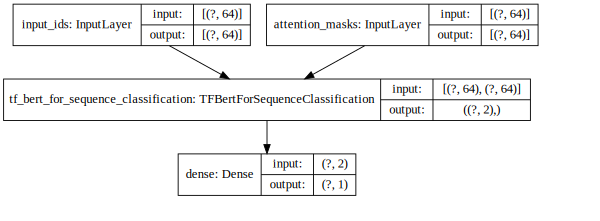

In [23]:
# 모델 네트워크 설정
input_ids = Input(batch_shape=(None, MAX_SEQUENCE_LEN), dtype=tf.int32, name='input_ids')
attention_masks = Input(batch_shape=(None, MAX_SEQUENCE_LEN), dtype=tf.int32, name='attention_masks')
output = bert_model([input_ids, attention_masks])[0] # logit
output = Dense(1, activation='sigmoid')(output) # sigmoid

model = Model(inputs=[input_ids, attention_masks], outputs=output, name='Bert_Classification')
model.compile(optimizer=Adam(learning_rate=3e-5),
              loss='binary_crossentropy')
print("Fine-Tuning 모델 구조 확인")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

# _5_. Training 


```
ResourceExhaustedError: 2 root error(s) found. (0) Resource exhausted: OOM when allocating tensor with shape[36864,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [[node Bert_Classification/tf_bert_for_sequence_classification/bert/encoder/layer_._3/intermediate/dense/Tensordot/MatMul (defined at /usr/local/lib/python3.6/dist-packages/transformers/modeling_tf_bert.py:341) ]] Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
```

-> https://github.com/huggingface/transformers/issues/180


In [24]:
# 모델 학습
try:
    model.load_weights(f"{model_path}/BERT-multilingual-NaverMovie.h5")
except:
    pass
    
hist = model.fit([X_train, X_train_masks], y_train,
                 validation_data=([X_test, X_test_masks], y_test),
                 batch_size=128,
                 epochs=3,
                 shuffle=True)    

Epoch 1/3
1166/1166 [==============================] - 1116s 957ms/step - loss: 0.4088 - val_loss: 0.3553
Epoch 2/3
1166/1166 [==============================] - 1114s 955ms/step - loss: 0.3192 - val_loss: 0.3341
Epoch 3/3
1166/1166 [==============================] - 1114s 955ms/step - loss: 0.2702 - val_loss: 0.3355


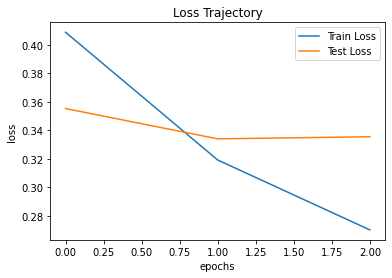

In [26]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.title('Loss Trajectory')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [27]:
# 사전학습 가중치 저장
model.save_weights(f"{model_path}/BERT-multilingual-NaverMovie.h5")

# _6_. Predicting

In [34]:
# 예측
# y_pred = model.predict([X_test, X_test_masks])
y_pred = np.where(y_pred > 0.5, 1, 0).reshape(-1, 1)
print('Accuracy = %.4f' % np.mean(y_test == y_pred))

Accuracy = 0.8576


#===================================

# Custom Model Trial
- We also provide a simple but feature-complete training and evaluation interface through Trainer() and TFTrainer(). You can train, fine-tune, and evaluate any 🤗 Transformers model with a wide range of training options and with built-in features like logging, gradient accumulation, and mixed precision.



## Config

* This is the configuration class to store the configuration of a BertModel. It is used to instantiate an BERT model according to the specified arguments, defining the model architecture. Instantiating a configuration with the defaults will yield a similar configuration to that of the BERT bert-base-uncased architecture.

In [ ]:
# # 모델 설정
# my_config = BertConfig.from_pretrained(
#     'bert-base-multilingual-cased',
#     num_labels=2,
#     output_hidden_states=False,
#     output_attentions=False
# )

In [ ]:
# # Pre-Trained 모델 불러오기
# model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', config=my_config)
# print(model.summary())

## Trainer

TFTrainer is a simple but feature-complete training and eval loop for TensorFlow, optimized for 🤗 Transformers.

- model (TFPreTrainedModel): The model to train, evaluate or use for predictions.
- args (TFTrainingArguments):  The arguments to tweak training.
- compute_metrics

In [ ]:
# # train 설정
# training_args = TFTrainingArguments(
#     output_dir= f"{model_path}/results", # output directory
#     num_train_epochs=3, # total # of training epochs
#     per_device_train_batch_size=16, # batch size per device during training
#     per_device_eval_batch_size=64, # batch size for evaluation
#     warmup_steps=500, # number of warmup steps for learning rate scheduler
#     weight_decay=0.01, # strength of weight decay
#     logging_dir=f"{model_path}/logs", # directory for storing logs
# )